Import libraries

In [27]:
import cv2
import json
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.activations import softmax, relu
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from random import shuffle
import time
%matplotlib inline

# tf.__version__
# "global" settings
main_folder = "./PetImages/"
exclude_folders = ["Kaggle Data", "glires", "lepidosauria","giraffe"]
width, height = 50, 50 # image definition

# files of X,y matrices ready for nn training
x_file = "./matrix_X.npy"
y_file = "./matrix_y.npy"
dict_file = "./dict.npy"

List dirs (folders) and create classes nomenclation

28 ['ape', 'bear', 'bee', 'beetle', 'bird', 'bos', 'canine', 'deer', 'elephants', 'feline', 'frogs', 'gekko', 'golden moles', 'hare', 'human', 'lemur', 'loris', 'none', 'rodent', 'salamander', 'scorpions', 'shark', 'sheep', 'snake', 'spider', 'squirrel', 'turtle', 'whale']
28 [939, 640, 660, 2933, 6160, 370, 700, 1079, 498, 620, 460, 2340, 728, 660, 4340, 2718, 1180, 360, 3229, 1293, 745, 679, 1349, 500, 2340, 1140, 320, 800]
smallest class:  turtle  with  320 occ.
biggest class:  bird  with  6160 occ.


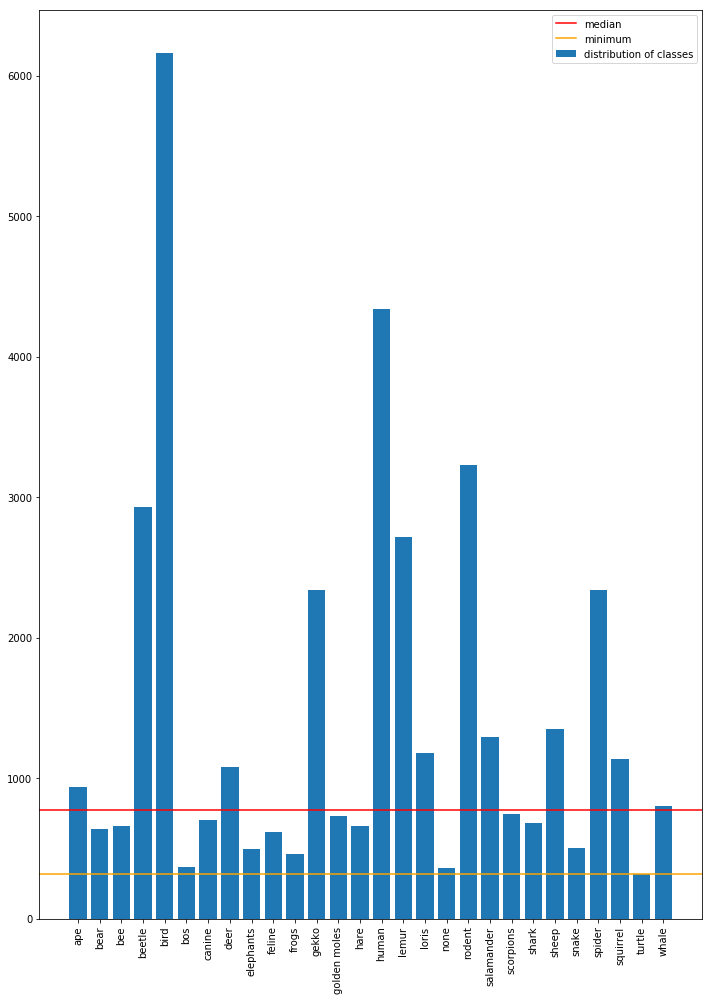

In [9]:
# look for images in folder PetImages and count images in folder
pictures_of_classes = os.listdir(main_folder)
class_list, class_poss_size = [], []
for class_folder in pictures_of_classes:
    if class_folder not in exclude_folders:
        class_list.append(class_folder)
        num_of_pics = len([name for name in os.listdir(os.path.join(main_folder,class_folder)) if os.path.isfile(os.path.join(main_folder,class_folder, name))])
        class_poss_size.append(num_of_pics)
        
# lazy-print summary of classes
print(len(class_list), class_list)
print(len(class_poss_size), class_poss_size)

# define dataframe
d = {"classes": class_list, "occ":class_poss_size}
class_stats = pd.DataFrame(data=d)
print("smallest class: ",class_list[np.argmin(class_poss_size)], " with ", np.min(class_poss_size) , "occ.")
print("biggest class: ",class_list[np.argmax(class_poss_size)], " with ", np.max(class_poss_size) , "occ.")

# plot all classes and number of occurences (images) per class
plt.figure(figsize=(10,14))
plt.bar(np.arange(len(class_poss_size)), class_poss_size, label="distribution of classes")
plt.xticks(np.arange(len(class_list)),class_list, rotation="vertical")
plt.axhline(np.median(class_poss_size),0,1,label="median", color="red")
plt.axhline(np.min(class_poss_size),0,1,label="minimum", color="orange")
plt.legend(loc="best")
plt.tight_layout()

In [10]:
class_stats

,classes,occ
0,ape,939
1,bear,640
2,bee,660
3,beetle,2933
4,bird,6160
5,bos,370
6,canine,700
7,deer,1079
8,elephants,498
9,feline,620


### Load images as test data and reshape to same size

In [11]:
class_dict = class_stats["classes"].to_dict()
print("Classes:\n",class_dict,"\n")
# read directories, resize and label data

# use 'smallest' class as batch size per class to ensure bias-free class representation during nn training
batch_size_per_class = np.min(class_poss_size)
batch_size = batch_size_per_class * len(class_list)

X = np.zeros((batch_size, height, width, 1)) # (batch, height, width, channels)
y = np.zeros((batch_size, len(class_list)))

# shape control
print("Shape of x: {} / y: {}".format(X.shape, y.shape))

# fill X,y matrices for each class with image and target data
for n_class in class_dict:
    print("Class number: {} | class name: {}".format(n_class, class_dict[n_class]))
    # calculate X,y ranges
    range_from = batch_size_per_class * n_class
    range_to = range_from + (batch_size_per_class)
    class_image_path = os.path.join(main_folder,class_dict[n_class])
    class_images = os.listdir(class_image_path)
    class_images = np.random.choice(class_images, batch_size_per_class, replace=False)
    print("Range in matrix from {} to {}.".format(range_from, range_to))
    for i in range(range_from,range_to):
        j = i
        if range_from > 0:
            j -= range_from
        try:
            print(i, ":", class_images[j])
            # resize image to width, height to reduce complexity
            img = cv2.imread(os.path.join(class_image_path,class_images[j]),cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)
            
        except Exception as e:
            print("Error while loading: ",e)
        else:
            # normalize pixel value to 0 - 1 to reduce complexity
            X[i,:,:,0] = img / 255
            y[i,n_class] = 1 # one hot encoding of target vector
            del img
print("Matrices X & y buildt!")

Classes:
 {0: 'ape', 1: 'bear', 2: 'bee', 3: 'beetle', 4: 'bird', 5: 'bos', 6: 'canine', 7: 'deer', 8: 'elephants', 9: 'feline', 10: 'frogs', 11: 'gekko', 12: 'golden moles', 13: 'hare', 14: 'human', 15: 'lemur', 16: 'loris', 17: 'none', 18: 'rodent', 19: 'salamander', 20: 'scorpions', 21: 'shark', 22: 'sheep', 23: 'snake', 24: 'spider', 25: 'squirrel', 26: 'turtle', 27: 'whale'} 

Shape of x: (8960, 50, 50, 1) / y: (8960, 28)
Class number: 0 | class name: ape
Range in matrix from 0 to 320.
0 : image_ape_hylobates albibarbis_113.jpg
1 : image_ape_pygathrix_378.jpg
2 : image_ape_hylobates moloch_179.jpg
3 : image_ape_lophocebus_137.jpg
4 : image_ape_semnopithecus_414.jpg
5 : image_ape_piliocolobus_316.jpg
6 : image_ape_lophocebus_133.jpg
7 : image_ape_mandrillus_167.jpg
8 : image_ape_hoolock hoolock_3.jpg
9 : image_ape_hylobates lar_156.jpg
10 : image_ape_allenopithecus_1.jpg
11 : image_ape_rhinopithecus_384.jpg
12 : image_ape_trachypithecus_446.jpg
13 : image_ape_colobus_278.jpg
14 : i

255 : image_ape_cercocebus_49.jpg
256 : image_ape_theropithecus_243.jpg
257 : image_ape_hylobates albibarbis_111.jpg
258 : image_ape_nomascus annamensis_222.jpg
259 : image_ape_hoolock leuconedys x hoolock tianxing_60.jpg
260 : image_ape_hoolock tianxing_72.jpg
261 : image_ape_allochrocebus_39.jpg
262 : image_ape_aotus azarai boliviensis_29.jpg
263 : image_ape_allochrocebus_33.jpg
264 : image_ape_papio_213.jpg
265 : image_ape_aotus azarai azarai_11.jpg
266 : image_ape_trachypithecus_452.jpg
267 : image_ape_allochrocebus_40.jpg
268 : image_ape_nomascus nasutus_367.jpg
269 : image_ape_macaca_156.jpg
270 : image_ape_allenopithecus_6.jpg
271 : image_ape_hylobates moloch_174.jpg
272 : image_ape_nomascus annamensis_229.jpg
273 : image_ape_cercocebus_50.jpg
274 : image_ape_lophocebus_132.jpg
275 : image_ape_nomascus leucogenys x nomascus siki_348.jpg
276 : image_ape_allochrocebus_28.jpg
277 : image_ape_hoolock hoolock_17.jpg
278 : image_ape_chlorocebus_100.jpg
279 : image_ape_cercocebus_57.jp

484 : image_bear_arctodus_42.jpg
485 : image_bear_ursus deningeri kudarensis_276.jpg
486 : image_bear_melursus_26.jpg
487 : image_bear_sitka brown bear_157.jpg
488 : image_bear_ursus arctos syriacus_242.jpg
489 : image_bear_ursus arctos arctos_149.jpg
490 : image_bear_blue bear_103.jpg
491 : image_bear_ursus americanus cinnamomum_88.jpg
492 : image_bear_ursus thibetanus thibetanus_400.jpg
493 : image_bear_ursus arctos horribilis_171.jpg
494 : image_bear_helarctos_2.jpg
495 : image_bear_ursus thibetanus thibetanus_390.jpg
496 : image_bear_ursus deningeri kudarensis_264.jpg
497 : image_bear_ursus thibetanus thibetanus_389.jpg
498 : image_bear_european brown bear_139.jpg
499 : image_bear_ursus thibetanus thibetanus_386.jpg
500 : image_bear_ursus americanus americanus_58.jpg
501 : image_bear_ursus arctos pruinosus_225.jpg
502 : image_bear_ursus thibetanus ussuricus_407.jpg
503 : image_bear_ursus americanus carlottae_72.jpg
504 : image_bear_melursus_40.jpg
505 : image_bear_ursus spelaeus er

668 : image_bee_xeromelissinae_314.jpg
669 : image_bee_bembicinae_504.jpg
670 : image_bee_astatinae_500.jpg
671 : image_bee_nomiinae_354.jpg
672 : image_bee_bembicinae_518.jpg
673 : image_bee_paracolletinae_276.jpg
674 : image_bee_bombinae_103.jpg
675 : image_bee_nomiinae_358.jpg
676 : image_bee_diphaglossinae_190.jpg
677 : image_bee_anthophorinae_69.jpg
678 : image_bee_halictinae_328.jpg
679 : image_bee_philanthinae_631.jpg
680 : image_bee_euryglossinae_210.jpg
681 : image_bee_crabroninae_524.jpg
682 : image_bee_xylocopinae_153.jpg
683 : image_bee_bembicinae_514.jpg
684 : image_bee_halictinae_335.jpg
685 : image_bee_mellininae_599.jpg
686 : image_bee_xeromelissinae_309.jpg
687 : image_bee_oxaeinae_27.jpg
688 : image_bee_rophitinae_390.jpg
689 : image_bee_xylocopinae_158.jpg
690 : image_bee_melittinae_471.jpg
691 : image_bee_bombinae_105.jpg
692 : image_bee_anthophorinae_63.jpg
693 : image_bee_melittinae_462.jpg
694 : image_bee_eremiaspheciinae_563.jpg
695 : image_bee_neopasiphaeinae_2

934 : image_bee_xylocopinae_156.jpg
935 : image_bee_rophitinae_387.jpg
936 : image_bee_nomioidinae_377.jpg
937 : image_bee_diphaglossinae_199.jpg
938 : image_bee_eremiaspheciinae_579.jpg
939 : image_bee_rophitinae_399.jpg
940 : image_bee_crabroninae_525.jpg
941 : image_bee_bombinae_102.jpg
942 : image_bee_euryglossinae_214.jpg
943 : image_bee_anthophorinae_73.jpg
944 : image_bee_xylocopinae_143.jpg
945 : image_bee_dinetinae_547.jpg
946 : image_bee_bembicinae_508.jpg
947 : image_bee_euryglossinae_203.jpg
948 : image_bee_meganomiinae_455.jpg
949 : image_bee_andreninae_17.jpg
950 : image_bee_bombinae_115.jpg
951 : image_bee_bembicinae_520.jpg
952 : image_bee_andreninae_1.jpg
953 : image_bee_anthophorinae_77.jpg
954 : image_bee_euryglossinae_218.jpg
955 : image_bee_mellininae_584.jpg
956 : image_bee_halictinae_323.jpg
957 : image_bee_oxaeinae_31.jpg
958 : image_bee_diphaglossinae_200.jpg
959 : image_bee_nomioidinae_376.jpg
Class number: 3 | class name: beetle
Range in matrix from 960 to 12

1197 : image_beetle_megacephala_1980.jpg
1198 : image_beetle_drypta_2449.jpg
1199 : image_beetle_callytron_1021.jpg
1200 : image_beetle_mecodema_369.jpg
1201 : image_beetle_craspedonotus_312.jpg
1202 : image_beetle_oxycheila_1521.jpg
1203 : image_beetle_chylnus_282.jpg
1204 : image_beetle_broscus_256.jpg
1205 : image_beetle_ctenostoma_1799.jpg
1206 : image_beetle_creobius_324.jpg
1207 : image_beetle_physodeutera_1611.jpg
1208 : image_beetle_microthylax_1429.jpg
1209 : image_beetle_coleolissus_2834.jpg
1210 : image_beetle_microcallisthenes_780.jpg
1211 : image_beetle_peridexia_1587.jpg
1212 : image_beetle_percolestus_445.jpg
1213 : image_beetle_therates_1727.jpg
1214 : image_beetle_microthylax_1434.jpg
1215 : image_beetle_campalita_629.jpg
1216 : image_beetle_bradybaenus_2744.jpg
1217 : image_beetle_pamborus_931.jpg
1218 : image_beetle_anthracus_2671.jpg
1219 : image_beetle_zecicindela_1761.jpg
1220 : image_beetle_teukrus_2414.jpg
1221 : image_beetle_ctenostoma_1794.jpg
1222 : image_bee

1454 : image_bird_coliiformes_583.jpg
1455 : image_bird_oxyruncidae_3487.jpg
1456 : image_bird_tichodromidae_4944.jpg
1457 : image_bird_tytonidae_2545.jpg
1458 : image_bird_polioptilidae_5021.jpg
1459 : image_bird_hirundinidae_4686.jpg
1460 : image_bird_falconiformes_3090.jpg
1461 : image_bird_sphenisciformes_2234.jpg
1462 : image_bird_aegotheliformes_457.jpg
1463 : image_bird_coliidae_2618.jpg
1464 : image_bird_scotocercidae_4752.jpg
1465 : image_bird_pedionomidae_1994.jpg
1466 : image_bird_philepittidae_3418.jpg
1467 : image_bird_teretistridae_5471.jpg
1468 : image_bird_odontophoridae_1066.jpg
1469 : image_bird_thinocoridae_1967.jpg
1470 : image_bird_oreophasinae_5685.jpg
1471 : image_bird_falconiformes_674.jpg
1472 : image_bird_casuarius casuarius_768.jpg
1473 : image_bird_odontophoridae_5885.jpg
1474 : image_bird_opisthocomiformes_6087.jpg
1475 : image_bird_prionopidae_4233.jpg
1476 : image_bird_cuculiformes_323.jpg
1477 : image_bird_cnemophilidae_4403.jpg
1478 : image_bird_strigop

1678 : image_bos_bos indicus_178.jpg
1679 : image_bos_bos taurus x bos indicus_346.jpg
1680 : image_bos_bos taurus x bos grunniens_329.jpg
1681 : image_bos_bos javanicus birmanicus x bos indicus_225.jpg
1682 : image_bos_bos sauveli_299.jpg
1683 : image_bos_bos taurus_315.jpg
1684 : image_bos_bos taurus_317.jpg
1685 : image_bos_bos grunniens_116.jpg
1686 : image_bos_bos grunniens_110.jpg
1687 : image_bos_bos javanicus birmanicus x bos indicus_236.jpg
1688 : image_bos_bos mutus_251.jpg
1689 : image_bos_bos sauveli_298.jpg
1690 : image_bos_bos gaurus x bos taurus_88.jpg
1691 : image_bos_bos primigenius_275.jpg
1692 : image_bos_bos primigenius_268.jpg
1693 : image_bos_bos frontalis_14.jpg
1694 : image_bos_bos taurus_307.jpg
1695 : image_bos_bos gaurus x bos taurus_83.jpg
1696 : image_bos_bos primigenius_273.jpg
1697 : image_bos_bos gaurus_74.jpg
1698 : image_bos_bos taurus_305.jpg
1699 : image_bos_bos javanicus_212.jpg
1700 : image_bos_bos mutus_254.jpg
1701 : image_bos_bos primigenius_262

1925 : image_canidae_canis mesomelas elongae_364.jpg
1926 : image_canidae_canis lupus desertorum_94.jpg
1927 : image_canidae_nyctereutes procyonoides viverrinus_477.jpg
1928 : image_canidae_canis lupus mogollonensis_273.jpg
1929 : image_canidae_nyctereutes procyonoides procyonoides_454.jpg
1930 : image_canidae_canis lupus signatus_317.jpg
1931 : image_canidae_nyctereutes procyonoides viverrinus_467.jpg
1932 : image_canidae_vulpes vulpes schrenckii_698.jpg
1933 : image_canidae_canis lupus labradorius_195.jpg
1934 : image_canidae_canis lupus laniger_214.jpg
1935 : image_canidae_canis lupus labradorius_189.jpg
1936 : image_canidae_canis lupus hodophilax_175.jpg
1937 : image_canidae_canis lupus x canis lupus familiaris_346.jpg
1938 : image_canidae_urocyon littoralis catalinae_500.jpg
1939 : image_canidae_canis lupus baileyi_38.jpg
1940 : image_canidae_canis mesomelas elongae_376.jpg
1941 : image_canidae_urocyon littoralis santarosae_588.jpg
1942 : image_canidae_canis lupus lupus_248.jpg
19

2109 : image_canidae_canis lupus desertorum_85.jpg
2110 : image_canidae_canis lupus familiaris_125.jpg
2111 : image_canidae_nyctereutes procyonoides koreensis_438.jpg
2112 : image_canidae_nyctereutes procyonoides koreensis_437.jpg
2113 : image_canidae_nyctereutes procyonoides viverrinus_474.jpg
2114 : image_canidae_canis lupus lupus_247.jpg
2115 : image_canidae_urocyon littoralis littoralis_551.jpg
2116 : image_canidae_vulpes vulpes montana_675.jpg
2117 : image_canidae_vulpes vulpes montana_678.jpg
2118 : image_canidae_nyctereutes procyonoides procyonoides_441.jpg
2119 : image_canidae_canis lupus pallipes_298.jpg
2120 : image_canidae_canis lupus dingo_109.jpg
2121 : image_canidae_canis lupus variabilis_328.jpg
2122 : image_canidae_vulpes lagopus beringensis_615.jpg
2123 : image_canidae_canis lupus lupaster_233.jpg
2124 : image_canidae_vulpes vulpes schrenckii_693.jpg
2125 : image_canidae_canis lupus lupaster_229.jpg
2126 : image_canidae_urocyon littoralis santacruzae_568.jpg
2127 : ima

2294 : image_deer_rucervus schomburgki_299.jpg
2295 : image_deer_pudu puda_1058.jpg
2296 : image_deer_muntiacus crinifrons_457.jpg
2297 : image_deer_muntiacus crinifrons_448.jpg
2298 : image_deer_odocoileus pandora_972.jpg
2299 : image_deer_muntiacus vaginalis_612.jpg
2300 : image_deer_megaloceros giganteus_218.jpg
2301 : image_deer_alces alces_652.jpg
2302 : image_deer_muntiacus gongshanensis_491.jpg
2303 : image_deer_megaloceros giganteus_210.jpg
2304 : image_deer_alces alces_657.jpg
2305 : image_deer_cervus nippon_127.jpg
2306 : image_deer_capreolus pygargus_732.jpg
2307 : image_deer_elaphurus davidianus_181.jpg
2308 : image_deer_cervus nippon_128.jpg
2309 : image_deer_hippocamelus antisensis_750.jpg
2310 : image_deer_rucervus eldii_269.jpg
2311 : image_deer_rusa unicolor_375.jpg
2312 : image_deer_mazama rufina_910.jpg
2313 : image_deer_ozotoceros bezoarticus_1018.jpg
2314 : image_deer_przewalskium albirostris_223.jpg
2315 : image_deer_muntiacus reevesi_559.jpg
2316 : image_deer_dam

2526 : image_deer_cervus nippon_130.jpg
2527 : image_deer_hippocamelus antisensis_745.jpg
2528 : image_deer_muntiacus atherodes_436.jpg
2529 : image_deer_odocoileus pandora_967.jpg
2530 : image_deer_muntiacus feae_472.jpg
2531 : image_deer_axis axis_12.jpg
2532 : image_deer_capreolus capreolus_715.jpg
2533 : image_deer_hippocamelus antisensis_749.jpg
2534 : image_deer_axis axis_1.jpg
2535 : image_deer_muntiacus atherodes_426.jpg
2536 : image_deer_cervus nippon_140.jpg
2537 : image_deer_muntiacus truongsonensis_589.jpg
2538 : image_deer_axis kuhlii_32.jpg
2539 : image_deer_capreolus pygargus_738.jpg
2540 : image_deer_muntiacus putaoensis_533.jpg
2541 : image_deer_odocoileus hemionus_956.jpg
2542 : image_deer_odocoileus virginianus_995.jpg
2543 : image_deer_muntiacus muntjak_511.jpg
2544 : image_deer_hydropotes inermis_383.jpg
2545 : image_deer_rusa timorensis_356.jpg
2546 : image_deer_mazama bororo_817.jpg
2547 : image_deer_odocoileus pandora_969.jpg
2548 : image_deer_rusa marianna_337.

2700 : image_elephants_elephas antiquus falconeri_29.jpg
2701 : image_elephants_mammut americanum_267.jpg
2702 : image_elephants_mammuthus columbi_282.jpg
2703 : image_elephants_elephas maximus_79.jpg
2704 : image_elephants_elephas maximus asurus_29.jpg
2705 : image_elephants_mammuthus jeffersonii_325.jpg
2706 : image_elephants_loxodonta africana knochenhaueri_126.jpg
2707 : image_elephants_loxodonta africana knochenhaueri_210.jpg
2708 : image_elephants_elephas cypriotes_45.jpg
2709 : image_elephants_elephas maximus sumatranus_167.jpg
2710 : image_elephants_elephas antiquus falconeri_24.jpg
2711 : image_elephants_elephas maximus maximus_147.jpg
2712 : image_elephants_elephas cypriotes_49.jpg
2713 : image_elephants_elephas maximus sumatranus_175.jpg
2714 : image_elephants_elephas antiquus falconeri_13.jpg
2715 : image_elephants_loxodonta africana_184.jpg
2716 : image_elephants_elephas maximus indicus_65.jpg
2717 : image_elephants_elephas maximus indicus_66.jpg
2718 : image_elephants_ele

2876 : image_elephants_elephas maximus indicus_125.jpg
2877 : image_elephants_mammuthus primigenius_358.jpg
2878 : image_elephants_loxodonta cyclotis_225.jpg
2879 : image_elephants_elephas maximus borneensis_111.jpg
Class number: 9 | class name: feline
Range in matrix from 2880 to 3200.
2880 : image_feline_panthera tigris sumatrae_589.jpg
2881 : image_feline_panthera pardus orientalis_459.jpg
2882 : image_feline_prionailurus bengalensis euptilurus_167.jpg
2883 : image_feline_panthera leo persica x panthera leo leo_346.jpg
2884 : image_feline_panthera pardus saxicolor_462.jpg
2885 : image_feline_prionailurus bengalensis chinensis_149.jpg
2886 : image_feline_prionailurus bengalensis euptilurus_162.jpg
2887 : image_feline_panthera tigris amoyensis_518.jpg
2888 : image_feline_panthera tigris tigris_602.jpg
2889 : image_feline_leopardus pardalis albescens_108.jpg
2890 : image_feline_panthera onca mesembrina_396.jpg
2891 : image_feline_prionailurus bengalensis euptilurus_175.jpg
2892 : image

3036 : image_feline_panthera leo persica x panthera leo leo_351.jpg
3037 : image_feline_panthera leo atrox_253.jpg
3038 : image_feline_felis silvestris lybica_41.jpg
3039 : image_feline_felis silvestris bieti_11.jpg
3040 : image_feline_panthera leo leo_320.jpg
3041 : image_feline_felis silvestris ornata_71.jpg
3042 : image_feline_panthera tigris sondaica_569.jpg
3043 : image_feline_panthera leo persica x panthera leo leo_342.jpg
3044 : image_feline_panthera leo leo_314.jpg
3045 : image_feline_panthera pardus orientalis_454.jpg
3046 : image_feline_panthera tigris corbetti_538.jpg
3047 : image_feline_panthera tigris corbetti_531.jpg
3048 : image_feline_felis silvestris ornata_73.jpg
3049 : image_feline_panthera tigris tigris_617.jpg
3050 : image_feline_panthera tigris jacksoni_542.jpg
3051 : image_feline_panthera leo spelaea_371.jpg
3052 : image_feline_panthera pardus fusca_413.jpg
3053 : image_feline_panthera leo persica x panthera leo leo_357.jpg
3054 : image_feline_panthera onca mesem

3244 : image_frogs_vibrissaphora_326.jpg
3245 : image_frogs_pelobates_372.jpg
3246 : image_frogs_ophryophryne_268.jpg
3247 : image_frogs_barbourula_91.jpg
3248 : image_frogs_brachytarsophrys_171.jpg
3249 : image_frogs_bombina_104.jpg
3250 : image_frogs_leptobrachium_215.jpg
3251 : image_frogs_spea_403.jpg
3252 : image_frogs_ascaphus_67.jpg
3253 : image_frogs_alytes_3.jpg
3254 : image_frogs_pelobates_371.jpg
3255 : image_frogs_discoglossus_22.jpg
3256 : image_frogs_spea_405.jpg
3257 : image_frogs_oreolalax_299.jpg
3258 : image_frogs_oreolalax_281.jpg
3259 : image_frogs_leiopelma_132.jpg
3260 : image_frogs_discoglossus_27.jpg
3261 : image_frogs_leptolalax_226.jpg
3262 : image_frogs_oreolalax_290.jpg
3263 : image_frogs_xenophrys_342.jpg
3264 : image_frogs_atympanophrys_157.jpg
3265 : image_frogs_oreolalax_294.jpg
3266 : image_frogs_xenophrys_346.jpg
3267 : image_frogs_latonia_48.jpg
3268 : image_frogs_megophrys_252.jpg
3269 : image_frogs_ascaphus_61.jpg
3270 : image_frogs_brachytarsophrys

3502 : image_frogs_brachytarsophrys_163.jpg
3503 : image_frogs_pelobates_374.jpg
3504 : image_frogs_atympanophrys_156.jpg
3505 : image_frogs_bombina_111.jpg
3506 : image_frogs_rhinophrynus_454.jpg
3507 : image_frogs_leptobrachella_189.jpg
3508 : image_frogs_discoglossus_31.jpg
3509 : image_frogs_alytes_7.jpg
3510 : image_frogs_barbourula_87.jpg
3511 : image_frogs_leiopelma_127.jpg
3512 : image_frogs_pelodytes_422.jpg
3513 : image_frogs_vibrissaphora_330.jpg
3514 : image_frogs_bombina_119.jpg
3515 : image_frogs_megophrys_253.jpg
3516 : image_frogs_leptobrachium_217.jpg
3517 : image_frogs_latonia_56.jpg
3518 : image_frogs_leptobrachella_183.jpg
3519 : image_frogs_leptobrachium_208.jpg
Class number: 11 | class name: gekko
Range in matrix from 3520 to 3840.
3520 : image_gekko_uvidicolus_1500.jpg
3521 : image_gekko_alsophylax_211.jpg
3522 : image_gekko_aristelliger_2139.jpg
3523 : image_gekko_ptenopus_1012.jpg
3524 : image_gekko_eurydactylodes_1653.jpg
3525 : image_gekko_diplodactylus_1631.

3735 : image_gekko_ptyodactylus_1378.jpg
3736 : image_gekko_mniarogekko_1752.jpg
3737 : image_gekko_haemodracon_1295.jpg
3738 : image_gekko_bogertia_260.jpg
3739 : image_gekko_christinus_348.jpg
3740 : image_gekko_geckolepis_566.jpg
3741 : image_gekko_ptenopus_1015.jpg
3742 : image_gekko_eurydactylodes_1642.jpg
3743 : image_gekko_paragehyra_1204.jpg
3744 : image_gekko_dierogekko_1611.jpg
3745 : image_gekko_kolekanos_747.jpg
3746 : image_gekko_lepidoblepharis_2217.jpg
3747 : image_gekko_eublepharis_33.jpg
3748 : image_gekko_diplodactylus_1635.jpg
3749 : image_gekko_rhynchoedura_1886.jpg
3750 : image_gekko_hemitheconyx_75.jpg
3751 : image_gekko_lucasium_1732.jpg
3752 : image_gekko_nactus_858.jpg
3753 : image_gekko_bunopus_272.jpg
3754 : image_gekko_geckolepis_577.jpg
3755 : image_gekko_ophidiocephalus_2057.jpg
3756 : image_gekko_paragehyra_1220.jpg
3757 : image_gekko_matoatoa_819.jpg
3758 : image_gekko_alsophylax_216.jpg
3759 : image_gekko_microgecko_1200.jpg
3760 : image_gekko_pseudogek

3911 : image_golden moles_eremitalpa granti namibensis_184.jpg
3912 : image_golden moles_amblysomus hottentotus meesteri_81.jpg
3913 : image_golden moles_amblysomus hottentotus longiceps_76.jpg
3914 : image_golden moles_amblysomus hottentotus longiceps_79.jpg
3915 : image_golden moles_amblysomus robustus_228.jpg
3916 : image_golden moles_amblysomus hottentotus_52.jpg
3917 : image_golden moles_neamblysomus gunningi_295.jpg
3918 : image_golden moles_carpitalpa arendsi_269.jpg
3919 : image_golden moles_cryptochloris wintoni_507.jpg
3920 : image_golden moles_amblysomus hottentotus iris_51.jpg
3921 : image_golden moles_cryptochloris wintoni_516.jpg
3922 : image_golden moles_calcochloris obtusirostris obtusirostris_178.jpg
3923 : image_golden moles_amblysomus hottentotus_51.jpg
3924 : image_golden moles_amblysomus hottentotus meesteri_130.jpg
3925 : image_golden moles_chlorotalpa sclateri_357.jpg
3926 : image_golden moles_chrysospalax villosus_484.jpg
3927 : image_golden moles_chlorotalpa sc

4095 : image_golden moles_amblysomus robustus_239.jpg
4096 : image_golden moles_chlorotalpa duthieae_336.jpg
4097 : image_golden moles_chlorotalpa sclateri_360.jpg
4098 : image_golden moles_chrysospalax trevelyani_462.jpg
4099 : image_golden moles_amblysomus hottentotus_42.jpg
4100 : image_golden moles_chlorotalpa duthieae_328.jpg
4101 : image_golden moles_calcochloris obtusirostris obtusirostris_180.jpg
4102 : image_golden moles_amblysomus corriae corriae_18.jpg
4103 : image_golden moles_amblysomus corriae_6.jpg
4104 : image_golden moles_chrysochloris stuhlmanni_459.jpg
4105 : image_golden moles_amblysomus corriae_3.jpg
4106 : image_golden moles_amblysomus iris_182.jpg
4107 : image_golden moles_amblysomus hottentotus iris_85.jpg
4108 : image_golden moles_amblysomus septentrionalis_248.jpg
4109 : image_golden moles_amblysomus hottentotus iris_84.jpg
4110 : image_golden moles_amblysomus hottentotus meesteri_89.jpg
4111 : image_golden moles_amblysomus hottentotus hottentotus_63.jpg
4112 

4269 : image_hare_lepus timidus x lepus europeus_561.jpg
4270 : image_hare_lepus flavigularis_280.jpg
4271 : image_hare_lepus sp._642.jpg
4272 : image_hare_lepus crawshayi_223.jpg
4273 : image_hare_lepus peguensis_446.jpg
4274 : image_hare_lepus townsendii_618.jpg
4275 : image_hare_lepus microtis_381.jpg
4276 : image_hare_lepus brachyurus_71.jpg
4277 : image_hare_lepus arcticus_54.jpg
4278 : image_hare_lepus tibetanus_525.jpg
4279 : image_hare_lepus alleni_12.jpg
4280 : image_hare_lepus coreanus_194.jpg
4281 : image_hare_lepus granatensis_288.jpg
4282 : image_hare_lepus townsendii_603.jpg
4283 : image_hare_lepus capensis_128.jpg
4284 : image_hare_lepus tolai_584.jpg
4285 : image_hare_lepus hainanus_324.jpg
4286 : image_hare_lepus crawshayi_237.jpg
4287 : image_hare_lepus tibetanus_532.jpg
4288 : image_hare_lepus brachyurus_68.jpg
4289 : image_hare_lepus mandshuricus_380.jpg
4290 : image_hare_lepus sinensis_490.jpg
4291 : image_hare_lepus yarkandensis_640.jpg
4292 : image_hare_lepus oth

Error while loading:  OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3718: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

4506 : image_human_Syriacs_3801.jpg
4507 : image_human_Cameroonians_782.jpg
4508 : image_human_Togolese_3981.jpg
4509 : image_human_Saint Kitts and Nevis_3261.jpg
4510 : image_human_Angolans_108.jpg
4511 : image_human_East Timorese_1186.jpg
4512 : image_human_Vietnamese_4240.jpg
4513 : image_human_Bahrainis_299.jpg
4514 : image_human_Cameroonians_794.jpg
4515 : image_human_Kyrgyzs_2192.jpg
4516 : image_human_Costa Ricans_986.jpg
4517 : image_human_Hong Kongers_1782.jpg
4518 : image_human_Vincentians_4257.jpg
4519 : image_human_Rwandans_3260.jpg
4520 : image_human_Liechtensteiners_2302.jpg
4521 : image_human_Réunionnais_3183.jpg
Error while loading:  OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3718: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

4522 : i

4740 : image_human_Colombians_924.jpg
4741 : image_human_Sammarinese_3336.jpg
4742 : image_human_Dominicans_1160.jpg
4743 : image_human_Georgians_1527.jpg
4744 : image_human_Chinese_908.jpg
4745 : image_human_Syrians_3826.jpg
4746 : image_human_Eritreans_1308.jpg
4747 : image_human_Zambians_4310.jpg
4748 : image_human_Swazi_3744.jpg
4749 : image_human_Liechtensteiners_2314.jpg
4750 : image_human_Albanians_30.jpg
4751 : image_human_Gambians_1512.jpg
4752 : image_human_Ugandans_4114.jpg
4753 : image_human_Kenyans_2117.jpg
4754 : image_human_Swedes_3777.jpg
4755 : image_human_Arubans_184.jpg
4756 : image_human_Bosniaks_515.jpg
4757 : image_human_Russians_3223.jpg
4758 : image_human_Gabonese_1496.jpg
4759 : image_human_Solomon Islanders_3566.jpg
4760 : image_human_Gibraltarians_1618.jpg
4761 : image_human_Czechs_1079.jpg
4762 : image_human_Tuvaluans_4097.jpg
4763 : image_human_Portuguese_3120.jpg
4764 : image_human_Basques_356.jpg
4765 : image_human_Tuvaluans_4082.jpg
4766 : image_human_Ma

4962 : image_lemur_lepilemur ruficaudatus_2222.jpg
4963 : image_lemur_eulemur fulvus mayottensis_180.jpg
4964 : image_lemur_avahi unicolor_844.jpg
4965 : image_lemur_hapalemur griseus meridionalis_1627.jpg
4966 : image_lemur_lepilemur aeeclis_1804.jpg
4967 : image_lemur_lepilemur mustelinus_2150.jpg
4968 : image_lemur_microcebus macarthurii_352.jpg
4969 : image_lemur_mirza zaza_633.jpg
4970 : image_lemur_eulemur fulvus mayottensis_1391.jpg
4971 : image_lemur_propithecus coquereli_927.jpg
4972 : image_lemur_hapalemur aureus_1557.jpg
4973 : image_lemur_cheirogaleus lavasoensis_52.jpg
4974 : image_lemur_microcebus griseorufus_268.jpg
4975 : image_lemur_cheirogaleus medius_83.jpg
4976 : image_lemur_microcebus margotmarshae_398.jpg
4977 : image_lemur_eulemur fulvus_1316.jpg
4978 : image_lemur_cheirogaleus sibreei_126.jpg
4979 : image_lemur_phaner parienti_705.jpg
4980 : image_lemur_avahi unicolor_843.jpg
4981 : image_lemur_lepilemur betsileo_1878.jpg
4982 : image_lemur_lepilemur sahamalazen

5145 : image_loris_perodicticus potto_813.jpg
5146 : image_loris_loris lydekkerianus lydekkerianus_572.jpg
5147 : image_loris_galago senegalensis braccatus_169.jpg
5148 : image_loris_galagoides thomasi_305.jpg
5149 : image_loris_otolemur monteiri monteiri_492.jpg
5150 : image_loris_loris tardigradus tardigradus_227.jpg
5151 : image_loris_nycticebus coucang insularis_736.jpg
5152 : image_loris_perodicticus potto ibeanus_845.jpg
5153 : image_loris_galago senegalensis braccatus_178.jpg
5154 : image_loris_loris lydekkerianus_545.jpg
5155 : image_loris_galagoides demidoff_222.jpg
5156 : image_loris_loris tardigradus tardigradus_659.jpg
5157 : image_loris_galago senegalensis senegalensis_198.jpg
5158 : image_loris_arctocebus aureus_516.jpg
5159 : image_loris_perodicticus potto_810.jpg
5160 : image_loris_galago gallarum_80.jpg
5161 : image_loris_galagoides thomasi_313.jpg
5162 : image_loris_galago alleni_29.jpg
5163 : image_loris_galagoides rondoensis_290.jpg
5164 : image_loris_galago senegal

5321 : image_loris_nycticebus menagensis_777.jpg
5322 : image_loris_galagoides demidoff_232.jpg
5323 : image_loris_loris tardigradus tardigradus_650.jpg
5324 : image_loris_galagoides demidoff murinus_47.jpg
5325 : image_loris_galagoides orinus_263.jpg
5326 : image_loris_galago matschiei_115.jpg
5327 : image_loris_nycticebus coucang coucang_250.jpg
5328 : image_loris_loris lydekkerianus_551.jpg
5329 : image_loris_galago senegalensis_153.jpg
5330 : image_loris_otolemur garnettii garnettii_426.jpg
5331 : image_loris_perodicticus potto edwarsi_290.jpg
5332 : image_loris_galago senegalensis_147.jpg
5333 : image_loris_otolemur crassicaudatus_391.jpg
5334 : image_loris_galago moholi_125.jpg
5335 : image_loris_loris lydekkerianus lydekkerianus_163.jpg
5336 : image_loris_perodicticus potto_809.jpg
5337 : image_loris_galago senegalensis braccatus_12.jpg
5338 : image_loris_loris lydekkerianus_544.jpg
5339 : image_loris_otolemur monteiri monteiri_144.jpg
5340 : image_loris_galago gabonensis_58.jpg

5533 : image_none_jungle nature images -animal_204.jpg
5534 : image_none_underwater ocean nature_128.jpg
5535 : image_none_jungle nature images_259.jpg
5536 : image_none_hill nature landscape_212.jpg
5537 : image_none_landscape images mountains_94.jpg
5538 : image_none_hill nature landscape_183.jpg
5539 : image_none_landscape images mountains_95.jpg
5540 : image_none_botanical garden images -animal_289.jpg
5541 : image_none_nature landscape macro ground_10.jpg
5542 : image_none_forest nature landscape_187.jpg
5543 : image_none_sahara desert water source -map -news_102.jpg
5544 : image_none_botanical garden images_261.jpg
5545 : image_none_hill nature landscape_198.jpg
5546 : image_none_jungle nature images_256.jpg
5547 : image_none_botanical garden images -animal_297.jpg
5548 : image_none_botanical garden images -animal_292.jpg
5549 : image_none_jungle nature images -animal_212.jpg
5550 : image_none_mountainside landscape nature_159.jpg
5551 : image_none_forest nature landscape_161.jpg

5706 : image_none_forest nature landscape_195.jpg
5707 : image_none_landscape images nature_62.jpg
5708 : image_none_hill nature landscape_191.jpg
5709 : image_none_jungle nature images_257.jpg
5710 : image_none_hill nature landscape_218.jpg
5711 : image_none_hill nature landscape_185.jpg
5712 : image_none_landscape images nature_79.jpg
5713 : image_none_landscape images nature_63.jpg
5714 : image_none_nature landscape macro ground_4.jpg
5715 : image_none_mountainside landscape swiss_179.jpg
5716 : image_none_underwater ocean nature_127.jpg
5717 : image_none_jungle nature images -animal_229.jpg
5718 : image_none_nature landscape macro ground_16.jpg
5719 : image_none_mountainside landscape nature_151.jpg
5720 : image_none_forest ground texture_32.jpg
5721 : image_none_jungle nature images -animal_238.jpg
5722 : image_none_forest nature landscape_192.jpg
5723 : image_none_hill nature landscape_188.jpg
5724 : image_none_jungle nature images -animal_222.jpg
5725 : image_none_forest nature 

5884 : image_rodent_thomomys bottae angularis_988.jpg
5885 : image_rodent_fukomys whytei occlusus_2611.jpg
5886 : image_rodent_thomomys bottae brevidens_1090.jpg
5887 : image_rodent_thomomys umbrinus tolucae_2462.jpg
5888 : image_rodent_thomomys talpoides immunis_2037.jpg
5889 : image_rodent_cavia aperea pamparum_2713.jpg
5890 : image_rodent_thomomys fulvus mutabilis_1757.jpg
5891 : image_rodent_thomomys bottae bottae_1078.jpg
5892 : image_rodent_geomys bursarius missouriensis_441.jpg
5893 : image_rodent_geomys bursarius industrius_356.jpg
5894 : image_rodent_thomomys umbrinus juntae_2365.jpg
5895 : image_rodent_cavia aperea guianae_2677.jpg
5896 : image_rodent_ctenomys minutus bicolor_2899.jpg
5897 : image_rodent_trinomys gratiosus bonafidei_2989.jpg
5898 : image_rodent_thomomys bottae cultellus_1165.jpg
5899 : image_rodent_thomomys umbrinus nelsoni_2390.jpg
5900 : image_rodent_geomys breviceps breviceps_254.jpg
5901 : image_rodent_thomomys townsendii bachmani_2199.jpg
5902 : image_ro

6070 : image_rodent_thomomys bottae saxatilis_1511.jpg
6071 : image_rodent_fukomys whytei occlusus_2617.jpg
6072 : image_rodent_thomomys fulvus osgoodi_1771.jpg
6073 : image_rodent_geomys personatus personatus_560.jpg
6074 : image_rodent_thomomys talpoides fossor_2001.jpg
6075 : image_rodent_thomomys bottae cultellus_1163.jpg
6076 : image_rodent_cryptomys hottentotus nimrodi_2588.jpg
6077 : image_rodent_thomomys anitae ruricola_797.jpg
6078 : image_rodent_thomomys umbrinus zacatecae_2489.jpg
6079 : image_rodent_lagidium viscacia cuvieri_2838.jpg
Class number: 19 | class name: salamander
Range in matrix from 6080 to 6400.
6080 : image_salamander_ambystoma amblycephalum_57.jpg
6081 : image_salamander_dicamptodon copei_857.jpg
6082 : image_salamander_salamandridae_135.jpg
6083 : image_salamander_ambystoma 'unisexual hybrid complex'_19.jpg
6084 : image_salamander_ambystoma annulatum_92.jpg
6085 : image_salamander_ambystoma amblycephalum_60.jpg
6086 : image_salamander_dicamptodon aterrimus_

6255 : image_salamander_amphiuma tridactylum_826.jpg
6256 : image_salamander_ambystoma ordinarium_572.jpg
6257 : image_salamander_ambystoma laterale-jeffersonianum complex sp. se1asr17_730.jpg
6258 : image_salamander_salamandridae_124.jpg
6259 : image_salamander_ambystoma altimirani_22.jpg
6260 : image_salamander_necturus maculosus_1027.jpg
6261 : image_salamander_ambystoma laterale_303.jpg
6262 : image_salamander_ambystoma ordinarium_584.jpg
6263 : image_salamander_rhyacotriton olympicus_1125.jpg
6264 : image_salamander_necturus beyeri_939.jpg
6265 : image_salamander_dicamptodon aterrimus_853.jpg
6266 : image_salamander_ambystoma altimirani_35.jpg
6267 : image_salamander_ambystoma gracile_247.jpg
6268 : image_salamander_ambystoma rivulare_590.jpg
6269 : image_salamander_ambystoma californiense x ambystoma tigrinum_166.jpg
6270 : image_salamander_ambystoma californiense x ambystoma tigrinum_176.jpg
6271 : image_salamander_ambystoma sp. 'salmoides'_743.jpg
6272 : image_salamander_ambyst

6434 : image_scorpions_buthacus occidentalis_402.jpg
6435 : image_scorpions_androctonus mauritanicus_279.jpg
6436 : image_scorpions_euscorpiidae_80.jpg
6437 : image_scorpions_buthacus yotvatensis_436.jpg
6438 : image_scorpions_australobuthus xerolimniorum_336.jpg
6439 : image_scorpions_superstitionidae_87.jpg
6440 : image_scorpions_caraboctonidae_129.jpg
6441 : image_scorpions_buthacus yotvatensis_424.jpg
6442 : image_scorpions_androctonus aeneas_130.jpg
6443 : image_scorpions_androctonus liouvillei_250.jpg
6444 : image_scorpions_australobuthus xerolimniorum_326.jpg
6445 : image_scorpions_buthacus occidentalis_420.jpg
6446 : image_scorpions_anomalobuthus rickmersi_292.jpg
6447 : image_scorpions_buthacus occidentalis_406.jpg
6448 : image_scorpions_scorpionidae_232.jpg
6449 : image_scorpions_superstitionidae_86.jpg
6450 : image_scorpions_ananteris franckei_101.jpg
6451 : image_scorpions_buthus atlantis_489.jpg
6452 : image_scorpions_alayotityus juraguaensis_25.jpg
6453 : image_scorpions_

6657 : image_scorpions_buthacus occidentalis_410.jpg
6658 : image_scorpions_pseudochactidae_242.jpg
6659 : image_scorpions_buthoscorpio politus_448.jpg
6660 : image_scorpions_buthoscorpio politus_444.jpg
6661 : image_scorpions_anomalobuthus rickmersi_299.jpg
6662 : image_scorpions_anomalobuthus rickmersi_286.jpg
6663 : image_scorpions_chactidae_41.jpg
6664 : image_scorpions_ananteris franckei_107.jpg
6665 : image_scorpions_androctonus australis_165.jpg
6666 : image_scorpions_babycurus centrurimorphus_343.jpg
6667 : image_scorpions_buthidae_10.jpg
6668 : image_scorpions_androctonus hoggarensis_231.jpg
6669 : image_scorpions_buthacus macrocentrus_382.jpg
6670 : image_scorpions_euscorpiidae_63.jpg
6671 : image_scorpions_alayotityus delacruzi_13.jpg
6672 : image_scorpions_buthus albengai_468.jpg
6673 : image_scorpions_androctonus liouvillei_244.jpg
6674 : image_scorpions_buthus albengai_469.jpg
6675 : image_scorpions_alayotityus juraguaensis_28.jpg
6676 : image_scorpions_pseudochactidae_24

6834 : image_shark_squalidae_182.jpg
6835 : image_shark_hexanchidae_45.jpg
6836 : image_shark_carcharhinus longimanus_379.jpg
6837 : image_shark_carcharhinus macloti_386.jpg
6838 : image_shark_carcharhinus amblyrhynchos_64.jpg
6839 : image_shark_carcharhinus falciformis_222.jpg
6840 : image_shark_carcharhinus brevipinna_152.jpg
6841 : image_shark_oxynotidae_153.jpg
6842 : image_shark_echinorhinidae_17.jpg
6843 : image_shark_centrophoridae_88.jpg
6844 : image_shark_carcharhinus longimanus_366.jpg
6845 : image_shark_carcharhinus amboinensis_88.jpg
6846 : image_shark_carcharhinus acronotus_4.jpg
6847 : image_shark_echinorhinidae_7.jpg
6848 : image_shark_carcharhinus isodon_293.jpg
6849 : image_shark_dalatiidae_113.jpg
6850 : image_shark_carcharhinus obscurus_429.jpg
6851 : image_shark_carcharhinus borneensis_109.jpg
6852 : image_shark_carcharhinus brevipinna_157.jpg
6853 : image_shark_pristiophoridae_68.jpg
6854 : image_shark_carcharhinus falciformis_235.jpg
6855 : image_shark_hexanchidae

7061 : image_sheep_ovis vignei arkal_992.jpg
7062 : image_sheep_capra aegagrus blythi_73.jpg
7063 : image_sheep_naemorhedus goral bedfordi_365.jpg
7064 : image_sheep_ovis vignei bochariensis_1031.jpg
7065 : image_sheep_ovis orientalis anatolica_879.jpg
7066 : image_sheep_capra falconeri heptneri_129.jpg
7067 : image_sheep_ovis orientalis gmelini_912.jpg
7068 : image_sheep_rupicapra rupicapra rupicapra_1318.jpg
7069 : image_sheep_rupicapra rupicapra balcanica_1238.jpg
7070 : image_sheep_ovis vignei vignei_1096.jpg
7071 : image_sheep_ovis ammon hodgsoni_495.jpg
7072 : image_sheep_pseudois nayaur szechuanensis_1153.jpg
7073 : image_sheep_capricornis milneedwardsii maritimus_287.jpg
7074 : image_sheep_rupicapra rupicapra rupicapra_1323.jpg
7075 : image_sheep_capra pyrenaica hispanica_219.jpg
7076 : image_sheep_capricornis milneedwardsii maritimus_290.jpg
7077 : image_sheep_budorcas taxicolor bedfordi_15.jpg
7078 : image_sheep_rupicapra rupicapra cartusiana_1283.jpg
7079 : image_sheep_naemo

7223 : image_sheep_rupicapra rupicapra asiatica_1217.jpg
7224 : image_sheep_ovis vignei cycloceros_1047.jpg
7225 : image_sheep_rupicapra pyrenaica ornata_1167.jpg
7226 : image_sheep_ovis ammon collium_437.jpg
7227 : image_sheep_ovis ammon hodgsoni_479.jpg
7228 : image_sheep_rupicapra pyrenaica pyrenaica_1215.jpg
7229 : image_sheep_ovis canadensis weemsi_727.jpg
7230 : image_sheep_budorcas taxicolor taxicolor_33.jpg
7231 : image_sheep_pseudois nayaur nayaur_1122.jpg
7232 : image_sheep_ovis vignei vignei_1111.jpg
7233 : image_sheep_ovis ammon hodgsoni_494.jpg
7234 : image_sheep_ovis aries musimon_582.jpg
7235 : image_sheep_ovis ammon collium_451.jpg
7236 : image_sheep_hemitragus jemlahicus schaferi_317.jpg
7237 : image_sheep_rupicapra pyrenaica ornata_1175.jpg
7238 : image_sheep_ovis canadensis weemsi_716.jpg
7239 : image_sheep_ovis ammon polii_543.jpg
7240 : image_sheep_ovis ammon nigrimontana_532.jpg
7241 : image_sheep_capra falconeri heptneri_136.jpg
7242 : image_sheep_rupicapra rupic

7447 : image_snake_dipsadinae_142.jpg
7448 : image_snake_notechinae_259.jpg
7449 : image_snake_xenodontinae_132.jpg
7450 : image_snake_acanthophiinae_169.jpg
7451 : image_snake_calamariinae_18.jpg
7452 : image_snake_atractaspidinae_298.jpg
7453 : image_snake_colubrinae_21.jpg
7454 : image_snake_pseudoxenodontinae_100.jpg
7455 : image_snake_colubrinae_31.jpg
7456 : image_snake_erycinae_499.jpg
7457 : image_snake_xenodontinae_128.jpg
7458 : image_snake_aparallactinae_271.jpg
7459 : image_snake_lamprophiinae_329.jpg
7460 : image_snake_crotalinae_435.jpg
7461 : image_snake_azemiopinae_411.jpg
7462 : image_snake_laticaudinae_223.jpg
7463 : image_snake_dipsadinae_144.jpg
7464 : image_snake_natricinae_69.jpg
7465 : image_snake_boodontinae_301.jpg
7466 : image_snake_xenodontinae_138.jpg
7467 : image_snake_atractaspidinae_290.jpg
7468 : image_snake_bungarinae_184.jpg
7469 : image_snake_bungarinae_193.jpg
7470 : image_snake_dipsadinae_146.jpg
7471 : image_snake_colubrinae_33.jpg
7472 : image_sna

7686 : image_spider_euctenizidae_2176.jpg
7687 : image_spider_actinopodidae_2037.jpg
7688 : image_spider_ctenidae_1192.jpg
7689 : image_spider_corinnidae_932.jpg
7690 : image_spider_actinopodidae_2031.jpg
7691 : image_spider_dictynidae_792.jpg
7692 : image_spider_agelenidae_675.jpg
7693 : image_spider_pisauridae_1255.jpg
7694 : image_spider_gnaphosidae_966.jpg
7695 : image_spider_nemesiidae_2281.jpg
7696 : image_spider_periegopidae_1726.jpg
7697 : image_spider_ammoxenidae_854.jpg
7698 : image_spider_zoropsidae_1315.jpg
7699 : image_spider_eutichuridae_1537.jpg
7700 : image_spider_uloboridae_511.jpg
7701 : image_spider_nephilidae_291.jpg
7702 : image_spider_corinnidae_921.jpg
7703 : image_spider_amaurobiidae_688.jpg
7704 : image_spider_lycosidae_1208.jpg
7705 : image_spider_dipluridae_2147.jpg
7706 : image_spider_corinnidae_939.jpg
7707 : image_spider_actinopodidae_2021.jpg
7708 : image_spider_migidae_2268.jpg
7709 : image_spider_lamponidae_999.jpg
7710 : image_spider_trachelidae_1923.j

7929 : image_spider_nemesiidae_2288.jpg
7930 : image_spider_gnaphosidae_967.jpg
7931 : image_spider_nicodamidae_1500.jpg
7932 : image_spider_pisauridae_1244.jpg
7933 : image_spider_austrochilidae_20.jpg
7934 : image_spider_nemesiidae_2292.jpg
7935 : image_spider_corinnidae_924.jpg
7936 : image_spider_dipluridae_2152.jpg
7937 : image_spider_homalonychidae_1443.jpg
7938 : image_spider_gnaphosidae_978.jpg
7939 : image_spider_microstigmatidae_2242.jpg
7940 : image_spider_gnaphosidae_965.jpg
7941 : image_spider_titanoecidae_1381.jpg
7942 : image_spider_trechaleidae_1956.jpg
7943 : image_spider_trachelidae_1926.jpg
7944 : image_spider_eresidae_54.jpg
7945 : image_spider_ammoxenidae_848.jpg
7946 : image_spider_stiphidiidae_1373.jpg
7947 : image_spider_trachelidae_1922.jpg
7948 : image_spider_cycloctenidae_1428.jpg
7949 : image_spider_pholcidae_1741.jpg
7950 : image_spider_gradungulidae_1545.jpg
7951 : image_spider_drymusidae_1786.jpg
7952 : image_spider_pisauridae_1252.jpg
7953 : image_spider

8147 : image_squirrel_trogopterus_625.jpg
8148 : image_squirrel_rubrisciurus_202.jpg
8149 : image_squirrel_protoxerus_1069.jpg
8150 : image_squirrel_spermophilopsis_1119.jpg
8151 : image_squirrel_eoglaucomys_427.jpg
8152 : image_squirrel_iomys_519.jpg
8153 : image_squirrel_tamias_954.jpg
8154 : image_squirrel_spermophilopsis_1109.jpg
8155 : image_squirrel_notocitellus_854.jpg
8156 : image_squirrel_iomys_506.jpg
8157 : image_squirrel_microsciurus_653.jpg
8158 : image_squirrel_petaurista_542.jpg
8159 : image_squirrel_poliocitellus_882.jpg
8160 : image_squirrel_rubrisciurus_214.jpg
8161 : image_squirrel_poliocitellus_888.jpg
8162 : image_squirrel_aeromys_396.jpg
8163 : image_squirrel_heliosciurus_1025.jpg
8164 : image_squirrel_urocitellus_967.jpg
8165 : image_squirrel_syntheosciurus_710.jpg
8166 : image_squirrel_petinomys_569.jpg
8167 : image_squirrel_urocitellus_961.jpg
8168 : image_squirrel_ratufa_322.jpg
8169 : image_squirrel_protoxerus_1080.jpg
8170 : image_squirrel_atlantoxerus_1094.

8390 : image_turtle_teleostomi_135.jpg
8391 : image_turtle_amniota_202.jpg
8392 : image_turtle_sauria_254.jpg
8393 : image_turtle_teleostomi_136.jpg
8394 : image_turtle_amniota_208.jpg
8395 : image_turtle_eumetazoa_27.jpg
8396 : image_turtle_dipnotetrapodomorpha_174.jpg
8397 : image_turtle_durocryptodira_284.jpg
8398 : image_turtle_tetrapoda_187.jpg
8399 : image_turtle_euteleostomi_153.jpg
8400 : image_turtle_vertebrata_91.jpg
8401 : image_turtle_eumetazoa_28.jpg
8402 : image_turtle_tetrapoda_197.jpg
8403 : image_turtle_teleostomi_138.jpg
8404 : image_turtle_sauria_249.jpg
8405 : image_turtle_sauria_256.jpg
8406 : image_turtle_deuterostomia_72.jpg
8407 : image_turtle_gnathostomata_116.jpg
8408 : image_turtle_opisthokonta_9.jpg
8409 : image_turtle_sauria_248.jpg
8410 : image_turtle_amniota_217.jpg
8411 : image_turtle_teleostomi_125.jpg
8412 : image_turtle_sauria_253.jpg
8413 : image_turtle_durocryptodira_289.jpg
8414 : image_turtle_opisthokonta_5.jpg
8415 : image_turtle_gnathostomata_10

8634 : image_turtle_gnathostomata_111.jpg
8635 : image_turtle_gnathostomata_114.jpg
8636 : image_turtle_archelosauria_274.jpg
8637 : image_turtle_amniota_213.jpg
8638 : image_turtle_americhelydia_313.jpg
8639 : image_turtle_archelosauria_263.jpg
Class number: 27 | class name: whale
Range in matrix from 8640 to 8960.
8640 : image_whale_platanista_651.jpg
8641 : image_whale_monodon_524.jpg
8642 : image_whale_grampus_220.jpg
8643 : image_whale_indopacetus_737.jpg
8644 : image_whale_steno_423.jpg
8645 : image_whale_sousa_400.jpg
8646 : image_whale_platanista_643.jpg
8647 : image_whale_inia_467.jpg
8648 : image_whale_inia_466.jpg
8649 : image_whale_steno_421.jpg
8650 : image_whale_sotalia_366.jpg
8651 : image_whale_delphinapterus_508.jpg
8652 : image_whale_caperea_106.jpg
8653 : image_whale_delphinapterus_510.jpg
8654 : image_whale_caperea_111.jpg
8655 : image_whale_megaptera_70.jpg
8656 : image_whale_stenella_418.jpg
8657 : image_whale_lipotes_489.jpg
8658 : image_whale_berardius_691.jpg
8

8862 : image_whale_feresa_178.jpg
8863 : image_whale_ziphius_786.jpg
8864 : image_whale_pontoporia_676.jpg
8865 : image_whale_sotalia_361.jpg
8866 : image_whale_inia_477.jpg
8867 : image_whale_phocoenoides_597.jpg
8868 : image_whale_steno_425.jpg
8869 : image_whale_platanista_652.jpg
8870 : image_whale_tursiops_451.jpg
8871 : image_whale_stenella_413.jpg
8872 : image_whale_neophocaena_545.jpg
8873 : image_whale_peponocephala_327.jpg
8874 : image_whale_balaenoptera_50.jpg
8875 : image_whale_globicephala_193.jpg
8876 : image_whale_kogia_613.jpg
8877 : image_whale_caperea_104.jpg
8878 : image_whale_delphinapterus_506.jpg
8879 : image_whale_lagenorhynchus_245.jpg
8880 : image_whale_orcaella_285.jpg
8881 : image_whale_kogia_619.jpg
8882 : image_whale_lissodelphis_262.jpg
8883 : image_whale_peponocephala_324.jpg
8884 : image_whale_cephalorhynchus_133.jpg
8885 : image_whale_caperea_116.jpg
8886 : image_whale_lagenodelphis_229.jpg
8887 : image_whale_orcinus_308.jpg
8888 : image_whale_peponocep

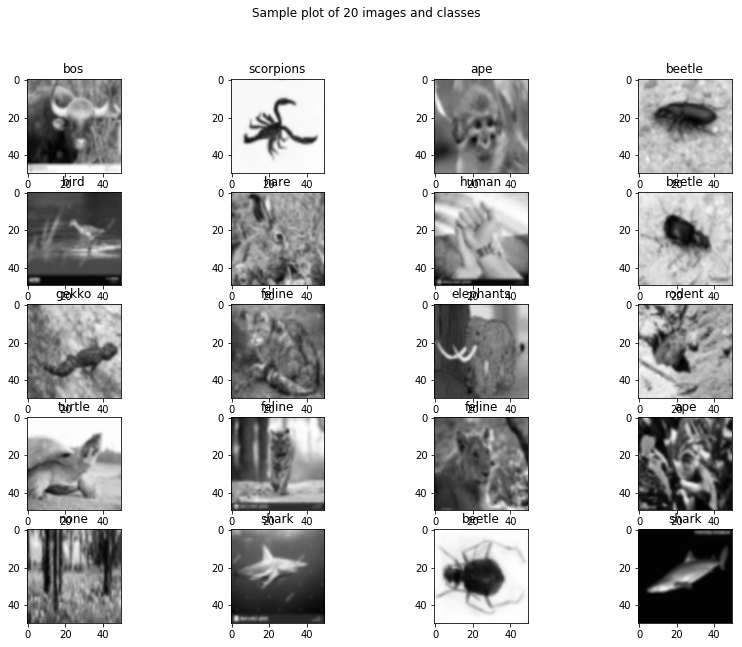

In [21]:
# quick visualization of images and classes
quick_test_number, cols_per_row = 20, 4
ids = np.random.choice(np.arange(X.shape[0]),quick_test_number, replace=False)
rows, cols = (quick_test_number//cols_per_row), cols_per_row
if quick_test_number%cols_per_row != 0:
    rows += 1

# plot random images and target informations
fig, axs = plt.subplots(rows,cols, figsize=(14,10))
col,row = 0,0
for id in ids:
    if col == 4:
        # next row, start from first column
        col = 0
        row += 1
    axs[row,col].imshow(X[id,:,:,0], cmap="gray", interpolation="bicubic")
    axs[row,col].set_title(class_dict[np.argmax(y[id])])
    col  += 1
fig.suptitle("Sample plot of {} images and classes".format(quick_test_number))
plt.show()

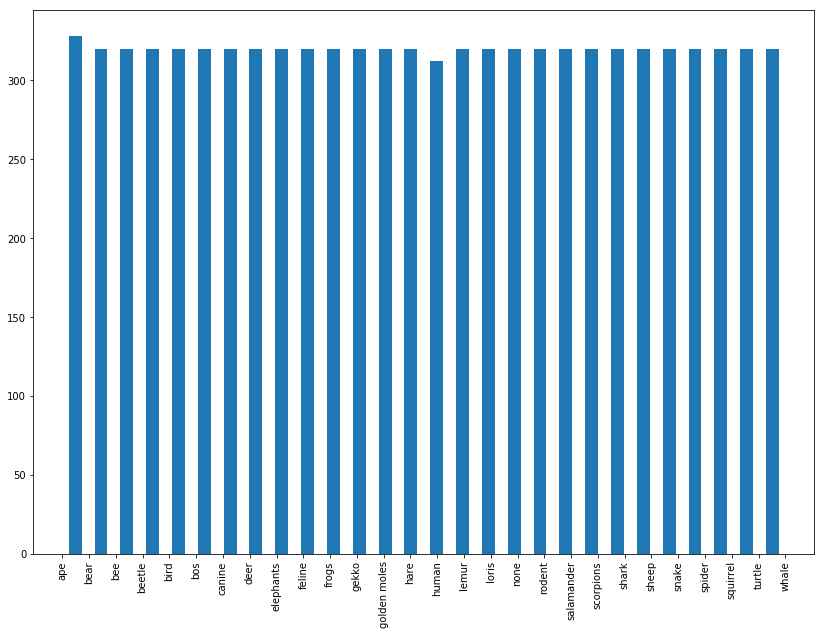

In [23]:
# plot class distribution of y matrix (target)
class_distrib = np.argmax(y, axis=1)
plt.figure(figsize=(14,10))
plt.hist(class_distrib, bins=len(class_list), rwidth=0.5)
plt.xticks(np.arange(len(class_list)),class_list, rotation="vertical")
plt.show()

Shuffle and balancing of data and target matrix before splitting them into training and test set

X shape: (8960, 50, 50, 1), Occs. in X_temp: 8960, Shape of X_temp[0]: (1, 50, 50, 1)
y shape: (8960, 28), Occs. in y_temp: 8960, Shape of y_temp[0]: (1, 28)
Resulting shape of X and y: (8960, 50, 50, 1) / (8960, 28) 


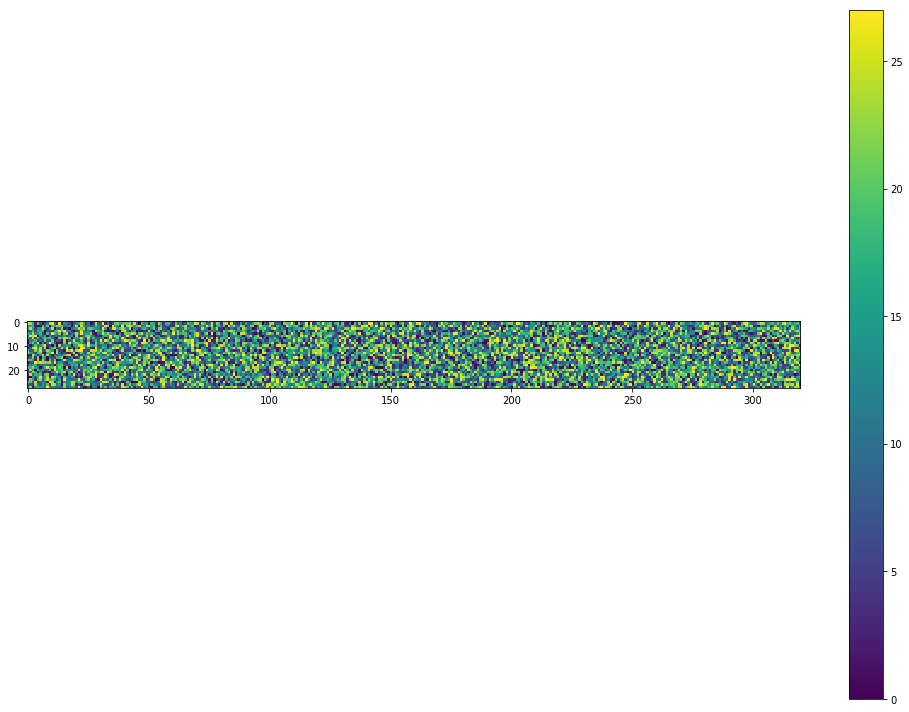

In [25]:
# shuffling of input data and target vector - before keras splits it in training and validation set
X_temp = np.split(X, X.shape[0], axis=0)
y_temp = np.split(y, y.shape[0], axis=0)
print("X shape: {}, Occs. in X_temp: {}, Shape of X_temp[0]: {}".format(X.shape, len(X_temp), X_temp[0].shape))
print("y shape: {}, Occs. in y_temp: {}, Shape of y_temp[0]: {}".format(y.shape, len(y_temp), y_temp[0].shape))

# create new, random order of sequences for data matrix and target vector
sequence_order = np.random.choice(np.arange(len(X_temp)), len(X_temp), replace=False)
X_final = np.zeros_like(X)
y_final = np.zeros_like(y)
for index, sequence in enumerate(sequence_order):
    X_final[index,:,:,:] = X_temp[sequence]
    y_final[index,:] = y_temp[sequence]
print("Resulting shape of X and y: {} / {} ".format(X_final.shape, y_final.shape))

# retrieve class of target matrix (argmax per row, not one hot encoded)
dist_matrix = np.reshape(np.argmax(y_final, axis=1),(len(class_list),batch_size_per_class))

# plot of shuffled target matrix y - visual check of shuffling process by show of class (argmax per row, not one hot encoded)
plt.figure(figsize=(14,10))
plt.imshow(dist_matrix)
plt.colorbar()
plt.tight_layout()
plt.show()

----


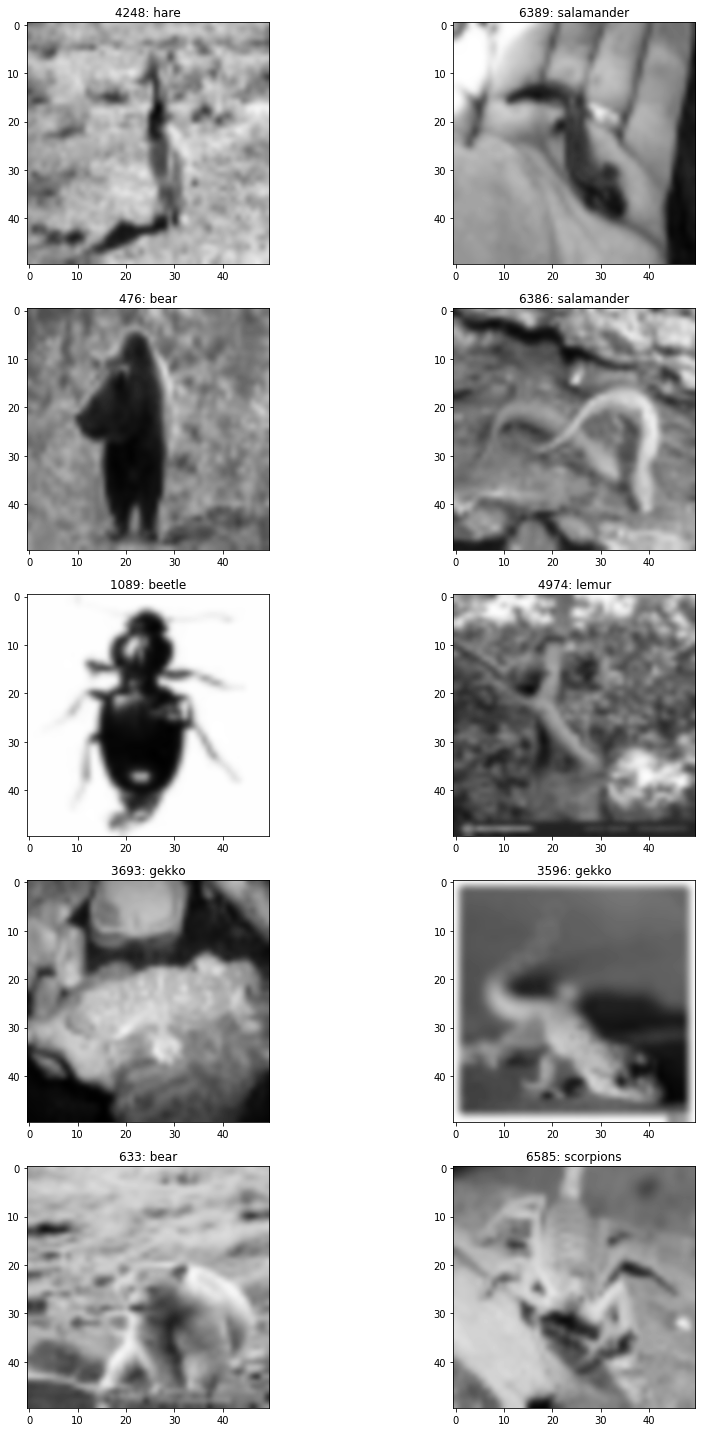

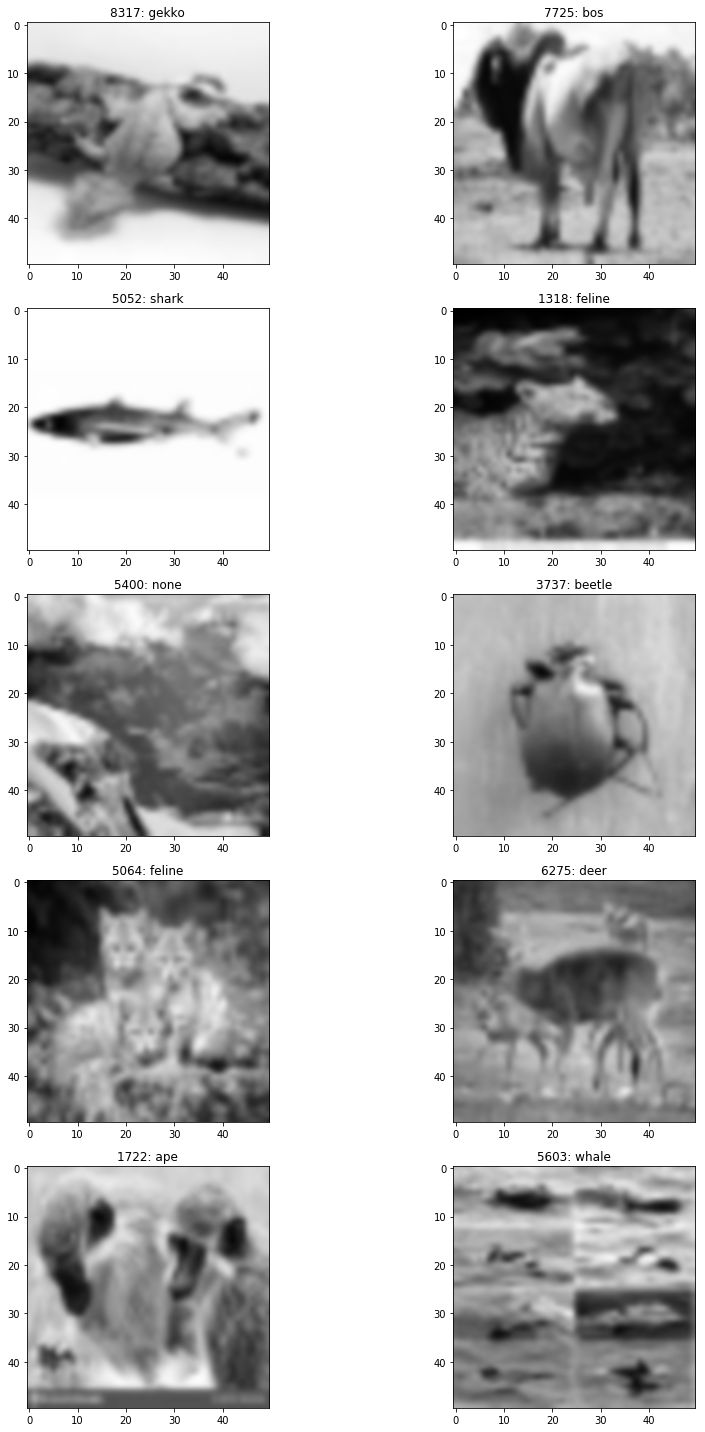

In [72]:
def show_random_sequences(X, y, amount, classes):
    plt.figure(figsize=(14, 20))
    for ind in range(amount): # only 10 first images
        rand_id = np.random.choice(X.shape[0], replace=False)
        plt.subplot(amount//2,2,ind+1)
        plt.imshow(X[rand_id,:,:,0], cmap="gray", interpolation="bicubic")
        plt.title("{}: {}".format(rand_id, classes[np.argmax(y[rand_id,:])], y[rand_id,:]))
    # print("w: {} | h: {}".format(width, height))
    plt.tight_layout()
    
show_random_sequences(X,y,10, class_list)
print("----")
show_random_sequences(X_final,y_final,10, class_list)

#### Option to save and load matrices X & y

In [75]:
# save matrices to (seperate) files - check settings on top of notebook

option_save = True # True for saving, False for loading (quick-fix for continuing working on notebook)

if option_save:
    np.save(x_file, X_final)
    np.save(y_file, y_final)
    with open(dict_file, "w") as f:
        json.dump(class_list, f)
    f.close()
    
else:
    X_final = np.load(x_file)
    y_final = np.load(y_file)
    with open(dict_file,"r") as f:
        class_dict = json.load(f)
    f.close()

## Build CNN with keras

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          51264     
_________________________________________________________________
max_pooling2d_3 (MaxP

Epoch 42/100
 - 21s - loss: 2.8094 - categorical_accuracy: 0.2026 - val_loss: 2.7777 - val_categorical_accuracy: 0.2433
Epoch 43/100
 - 20s - loss: 2.7851 - categorical_accuracy: 0.2033 - val_loss: 2.7618 - val_categorical_accuracy: 0.2359
Epoch 44/100
 - 19s - loss: 2.8004 - categorical_accuracy: 0.2044 - val_loss: 2.7840 - val_categorical_accuracy: 0.2344
Epoch 45/100
 - 19s - loss: 2.7987 - categorical_accuracy: 0.2022 - val_loss: 2.7780 - val_categorical_accuracy: 0.2351
Epoch 46/100
 - 20s - loss: 2.7780 - categorical_accuracy: 0.2037 - val_loss: 2.7565 - val_categorical_accuracy: 0.2351
Epoch 47/100
 - 20s - loss: 2.7655 - categorical_accuracy: 0.2075 - val_loss: 2.7591 - val_categorical_accuracy: 0.2336
Epoch 48/100
 - 19s - loss: 2.7558 - categorical_accuracy: 0.2067 - val_loss: 2.7589 - val_categorical_accuracy: 0.2433
Epoch 49/100
 - 19s - loss: 2.7609 - categorical_accuracy: 0.2113 - val_loss: 2.7421 - val_categorical_accuracy: 0.2411
Epoch 50/100
 - 19s - loss: 2.7455 - cat

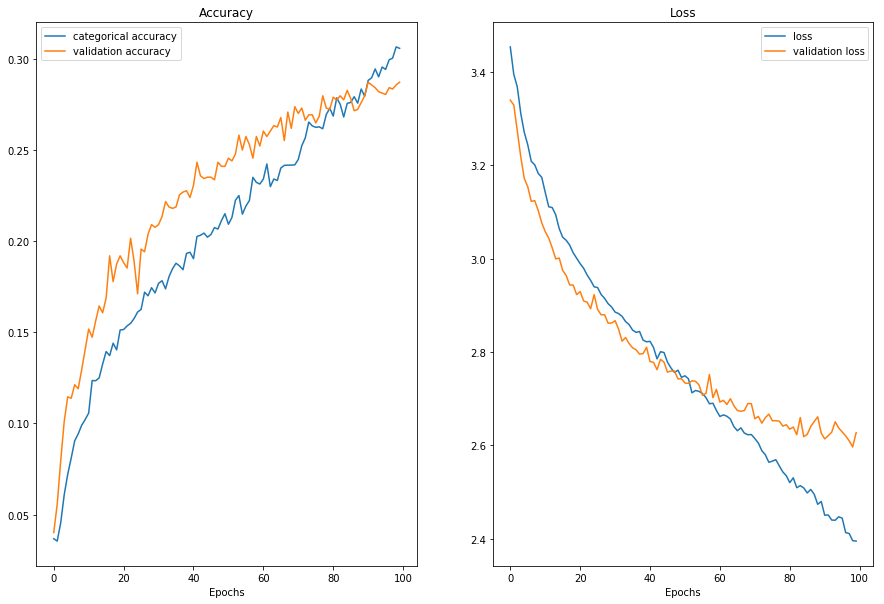

In [29]:
# model structure: conv - pool - conv - pool - fc dense - dense (output)
conv_kernel_size = (5,5)
conv_filters = 16
MaxPool_pool_size = (2, 2)
MaxPool_strides = (2, 2)
model = Sequential()
keep_rate = 0.5 # previously dropout rate -> prevent keras warning
# (batch, height, width, channels) - input format
model.add(Conv2D(filters=conv_filters, kernel_size=conv_kernel_size, strides=(1, 1), padding='valid', activation="relu", input_shape=(height,width,1)))
model.add(MaxPool2D(pool_size=MaxPool_pool_size, strides=MaxPool_strides, padding='valid'))

model.add(Conv2D(filters=2*conv_filters, kernel_size=conv_kernel_size, strides=(1, 1), padding='valid', activation="relu"))
model.add(MaxPool2D(pool_size=MaxPool_pool_size, strides=MaxPool_strides, padding='valid'))

model.add(Conv2D(filters=4*conv_filters, kernel_size=conv_kernel_size, strides=(1, 1), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=MaxPool_pool_size, strides=MaxPool_strides, padding='same'))

model.add(Conv2D(filters=2*conv_filters, kernel_size=conv_kernel_size, strides=(1, 1), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=MaxPool_pool_size, strides=MaxPool_strides, padding='same'))

model.add(Conv2D(filters=conv_filters, kernel_size=conv_kernel_size, strides=(1, 1), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=MaxPool_pool_size, strides=MaxPool_strides, padding='same'))
model.add(Dropout(rate=keep_rate))

model.add(Flatten())
model.add(Dense(256, activation="sigmoid"))
model.add(Dropout(rate=keep_rate/2))
model.add(Dense(len(class_list), activation="softmax"))

model.compile(optimizer=Adam(lr=1e-4, decay=1e-8), loss="categorical_crossentropy", metrics=["categorical_accuracy"])
model.summary()

# fit model with test data - with EarlyStopping on loss to prevent overfitting
# use (last) 15% of training data as validation set
start_time = time.time()
cb = EarlyStopping(monitor='loss', min_delta=1e-4, patience=5, verbose=2, restore_best_weights=True)
hist = model.fit(X_final,y_final, batch_size=32, epochs=100, verbose=2, validation_split=0.15, shuffle=True, callbacks=[cb])
ellapsed_time = (time.time() - start_time) / 60
print("Training took {} minutes.".format(ellapsed_time))

# plot training of CNN
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist.history["categorical_accuracy"], label="categorical accuracy")
plt.plot(hist.history["val_categorical_accuracy"], label="validation accuracy")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.title("Accuracy")
plt.subplot(1,2,2)
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="validation loss")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.title("Loss")
plt.show()

3 of 12 predictions correct.


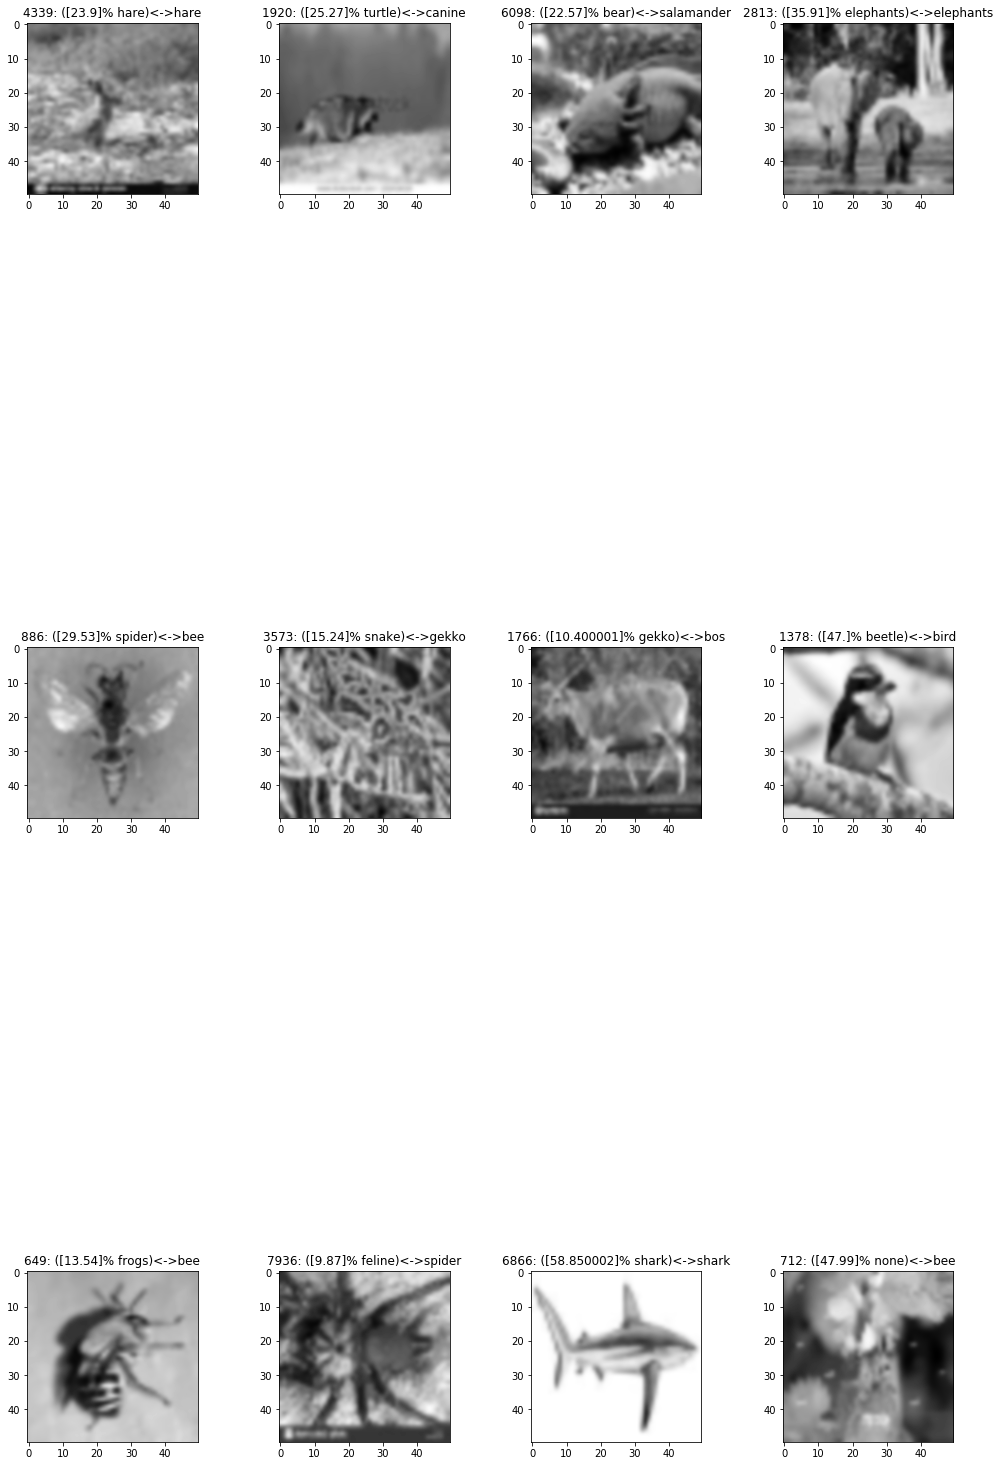

In [31]:
amount_test = 12
amount_cols = 4
amount_rows = amount_test//amount_cols
if amount_test%amount_cols > 0:
    amount_rows += 1
    
# create rectangular frame of plots
fig, ax = plt.subplots(amount_rows,amount_cols, figsize=(14,30))
correct_pred = 0 # keep tally of correct predictions
for i in range(amount_rows):
    rand_id = np.random.choice(X.shape[0],amount_cols, replace=False)
    for number, id in enumerate(rand_id):
        t_img = X[id,:,:,0].reshape(1,50,50,1) # reshape random id to use as input in keras model
        pred = model.predict_classes(t_img, verbose=0) # get class of prediction
        pred_ = model.predict(t_img, verbose=0) # get prediction values
        if class_dict[pred[0]] == class_dict[np.argmax(y[id,:])]:
            correct_pred += 1
        ax[i,number].imshow(X[id,:,:,0], cmap="gray", interpolation="bicubic")
        # plot image (interpolation just for display purposes)
        ax[i,number].set_title("{}: ({}% {})<->{}".format(id,
                                                         np.round(pred_[0][pred], decimals=4)*100,
                                                         class_dict[pred[0]],
                                                         class_dict[np.argmax(y[id,:])]
                                                        ))
fig.tight_layout()
print("{} of {} predictions correct.".format(correct_pred,amount_test))

Run model with whole data and target matrices to get score

In [33]:
score = model.evaluate(X_final, y_final, verbose=1, batch_size=32)
print("{}: {} / {}: {}".format(model.metrics_names[0],score[0], model.metrics_names[1], score[1]))

8960/8960 [==============================] - 5s 525us/step
loss: 2.1991664367062707 / categorical_accuracy: 0.384375


Save model with weights as well as class dict

In [51]:
datum = time.strftime("%Y_%m_%d")
model_identifier = "{}_cnn_conv_pool_conv_pool_drop_flatten_dense_dense_acc_{}".format(datum,
                                                                                       score[1])
model.save("{}.h5".format(model_identifier))

with open("./{}_classes.txt".format(datum),"w") as f:
    json.dump(class_dict,f)
f.close()

### What does the cnn see? What has the model learned?
orgins from: https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md but adapted

C:\Users\Maxime Sorgenfrei\AppData\Local\conda\conda\envs\mainenv\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


IndexError: too many indices for array

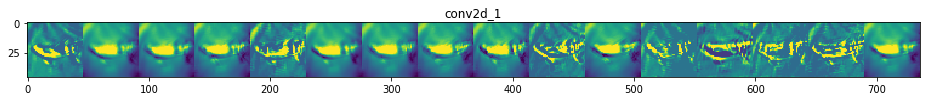

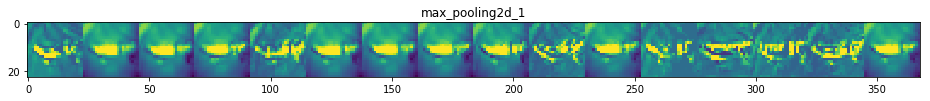

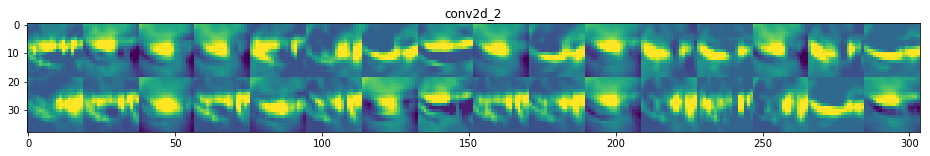

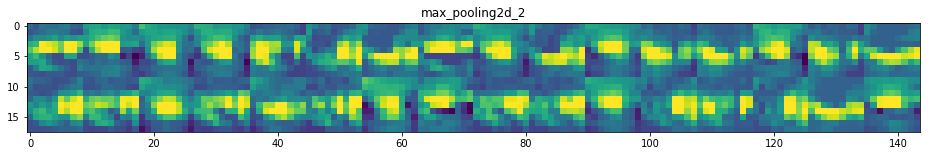

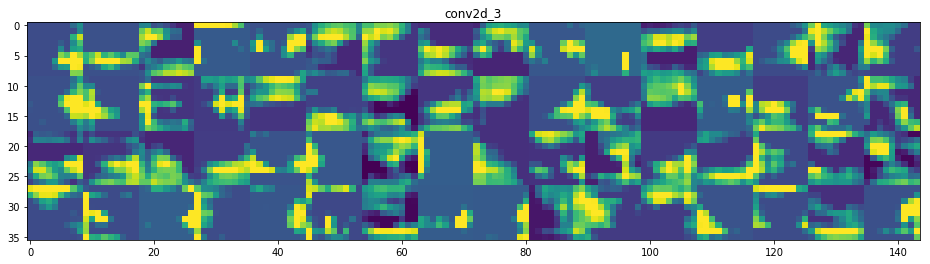

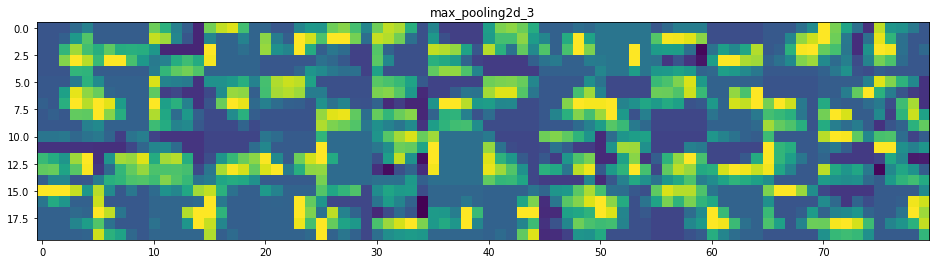

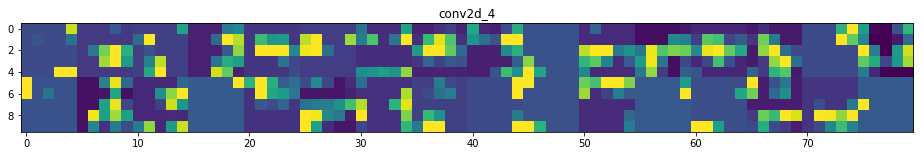

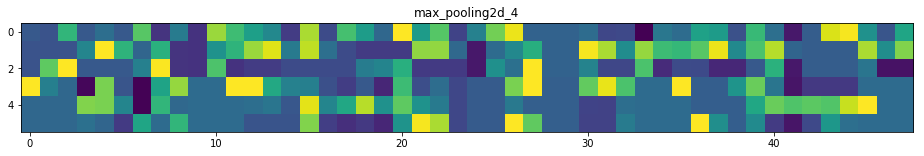

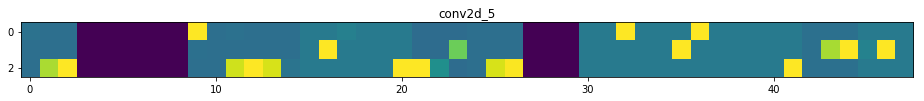

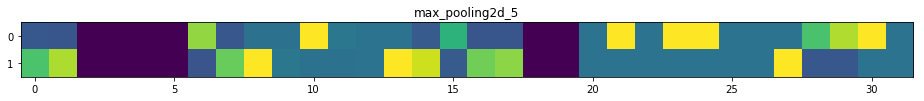

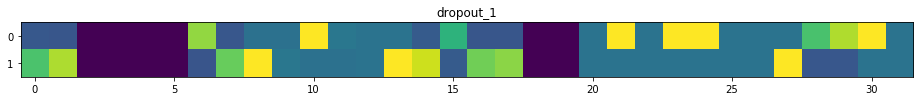

In [52]:
layer_outputs = [layer.output for layer in model.layers[:12]]
# Extracts the outputs of the top 12 layers
activation_model = Model(inputs=model.input, outputs=layer_outputs)
# Creates a model that will return these outputs, given the model input
img_tensor = X[-55,:,:,0].reshape(1,50,50,1) # for 55th image in X from end
activations = activation_model.predict(img_tensor)
# Returns a list of five Numpy arrays: one array per layer activation

layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')